#### Business understanding of problem
A company wants to create a predictive maintenance solution to reduce costs.
The solution will use machine learning to predict device failures.
The goal is to minimize false positives and false negatives.

##### Main Objective
The data set aims to precisely predict the RUL of a filter. The data set contains training and test data, each with 50 life tests. The test data contains randomly right-censored run-to-failure measurements and the respective RUL. The main challenge is how to make the most use of the right-censored life data.

##### Business Impact
The company benefits from making most use of the filters to avoid frequent replacements. 

Data set Creator:
Hochschule Esslingen - University of Applied Sciences
Research Department Reliability Engineering and Prognostics and Health Management
Robert-Bosch-Straße 1
73037 Göppingen
Germany
Kaggle:
https://www.kaggle.com/datasets/prognosticshse/preventive-to-predicitve-maintenance/data

Dataset Citation:
Hagmeyer, S., Mauthe, F., & Zeiler, P. (2021). Creation of Publicly Available Data Sets for Prognostics and Diagnostics Addressing Data Scenarios Relevant to Industrial Applications. International Journal of Prognostics and Health Management, Volume 12, Issue 2, DOI: 10.36001/ijphm.2021.v12i2.3087

In [1]:
# Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine Learning algorithms
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Keras for RNN
from keras.models import load_model
from keras.callbacks import EarlyStopping 
from keras.models import Sequential
from keras.layers import Dense, Dropout, ConvLSTM2D, LSTM, Activation

## Data loading and preparation

In [2]:
# Load the data in kaggle
train_df = pd.read_csv('data/Train_Data_CSV.csv')
test_df = pd.read_csv('data/Test_Data_CSV.csv')

In [3]:
train_df.head()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust
0,1,0.0,0.0,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust"
1,1,0.0,0.0,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust"
2,1,0.0,0.0,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust"
3,1,0.0,0.0,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust"
4,1,0.0,0.0,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust"


In [4]:
test_df.head()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.271267,52.281993,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.9
1,1,0.361690,54.986671,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.8
2,1,0.000000,55.424786,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.7
3,1,2.622251,55.524146,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.6
4,1,3.888165,55.852018,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.5


Test and train datasets look similar, except the test dataset has additional column called RUL (remaining useful life)

In [5]:
train_df.describe()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed
count,39420.000000,39420.000000,39420.000000,39420.000000,39420.000000
mean,25.167453,78.232050,66.095780,49.135490,132.247854
std,14.315149,107.342894,11.306582,39.088269,62.716754
min,1.000000,0.000000,0.000000,0.100000,59.107236
25%,12.000000,8.590133,58.458498,19.800000,79.246266
50%,24.000000,35.174340,59.040107,39.900000,118.214472
75%,38.000000,102.358200,81.136739,65.800000,158.492533
max,50.000000,607.910200,84.199355,179.400000,316.985065


There are about 39420 datapoints in training data set with maximum of 50 different time series values.

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39414 entries, 0 to 39413
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Data_No                39414 non-null  int64  
 1   Differential_pressure  39414 non-null  float64
 2   Flow_rate              39414 non-null  float64
 3   Time                   39414 non-null  float64
 4   Dust_feed              39414 non-null  float64
 5   Dust                   39414 non-null  object 
 6   RUL                    39414 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.1+ MB


In [7]:
feature_names = test_df.columns
print(feature_names)

Index(['Data_No', 'Differential_pressure', 'Flow_rate', 'Time', 'Dust_feed',
       'Dust', 'RUL'],
      dtype='object')


Both train and test data are part of accelerated lifetest dataset. The individual measurement series are contained in the training and test data, with the recorded data and the necessary setting parameters on the programmable logic controller (PLC). The dust used are specified. Dust_feed is the loading of the filter with dust per time (mm3/s).The “Sampling”  indicates the frequency at which the measurement data is recorded (Hz). In the Measurement data, the measured differential pressure and flow rate are listed at each point in time. In addition, the known RUL is specified for the randomly censored test data.

In [8]:
# checking for missing values
train_df.isnull().sum()

Data_No                  0
Differential_pressure    0
Flow_rate                0
Time                     0
Dust_feed                0
Dust                     0
dtype: int64

## Data analysis and plotting

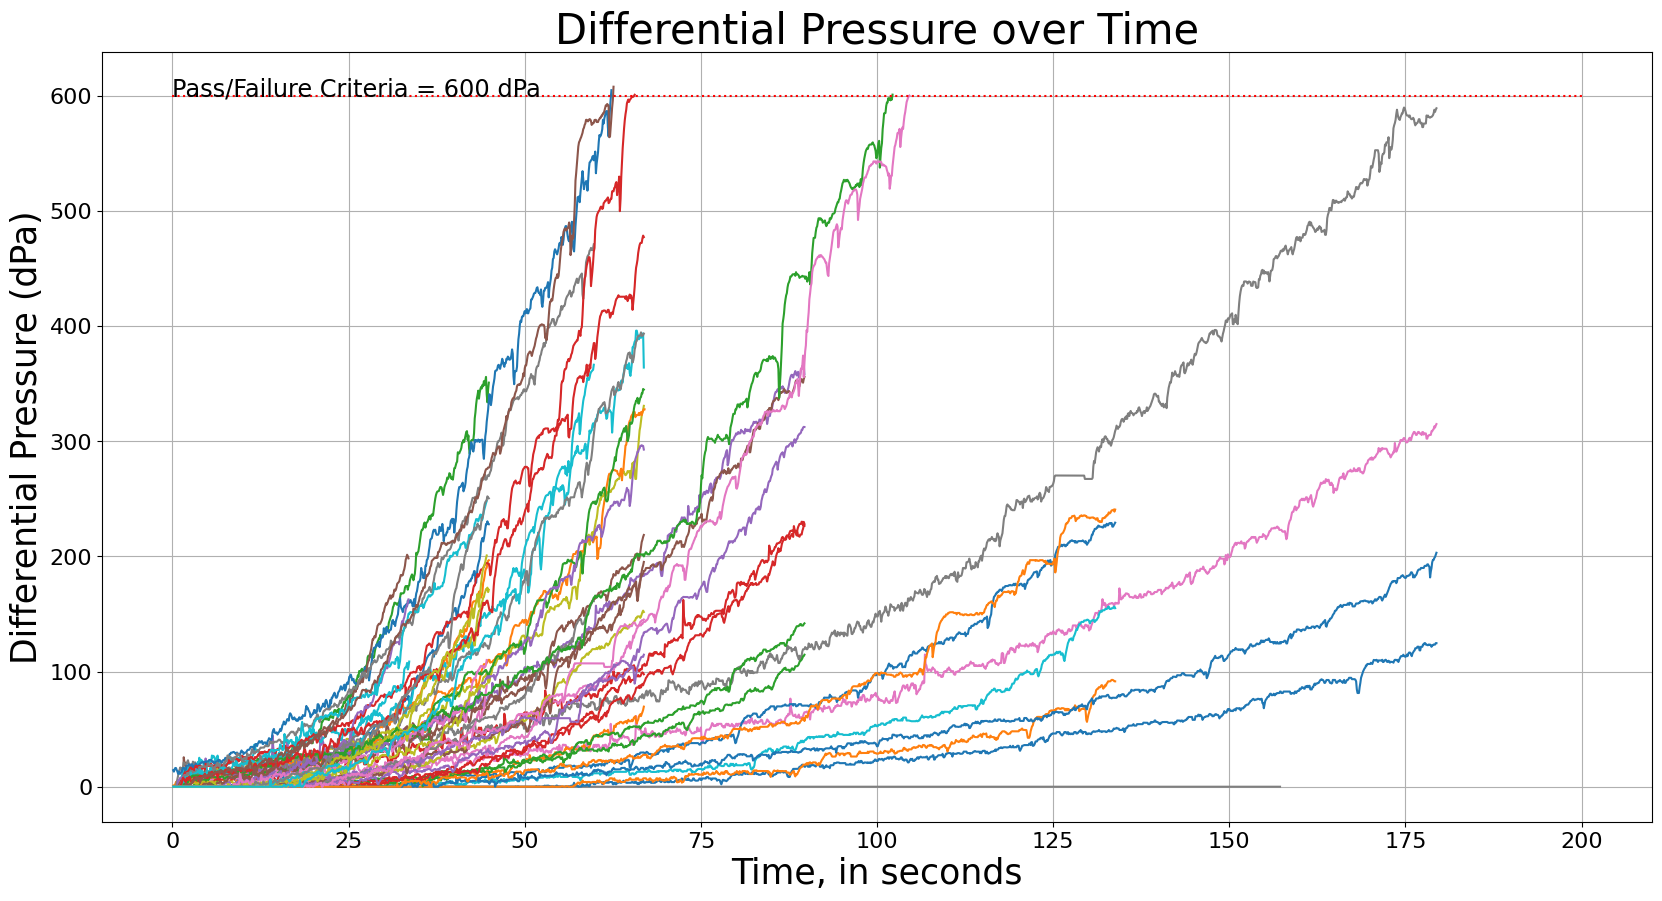

In [9]:
# differential pressure overtime
plt.figure(figsize = (20,10))
for data_no, df in train_df.groupby('Data_No'):
    plt.plot(df['Time'], df['Differential_pressure'])
    
plt.xlabel('Time, in seconds', fontsize=25)
plt.ylabel('Differential Pressure (dPa)', fontsize=25)
plt.tick_params(axis='both', labelsize=16)
plt.title('Differential Pressure over Time', fontsize=30)
plt.grid()
x= [0, 25, 50, 75, 200]
y= [600, 600, 600, 600, 600]

#plt line
plt.plot(x,y, color='red', linestyle='dotted')
plt.text(0, 600, "Pass/Failure Criteria = 600 dPa", fontdict=None, fontsize = 'xx-large')
plt.show()

The filter failure occurs when the differential pressure across the filter exceeds 600 Pa. Looks like there are 5 readings in the dataset where differential pressure exceeds 600 Pa. 

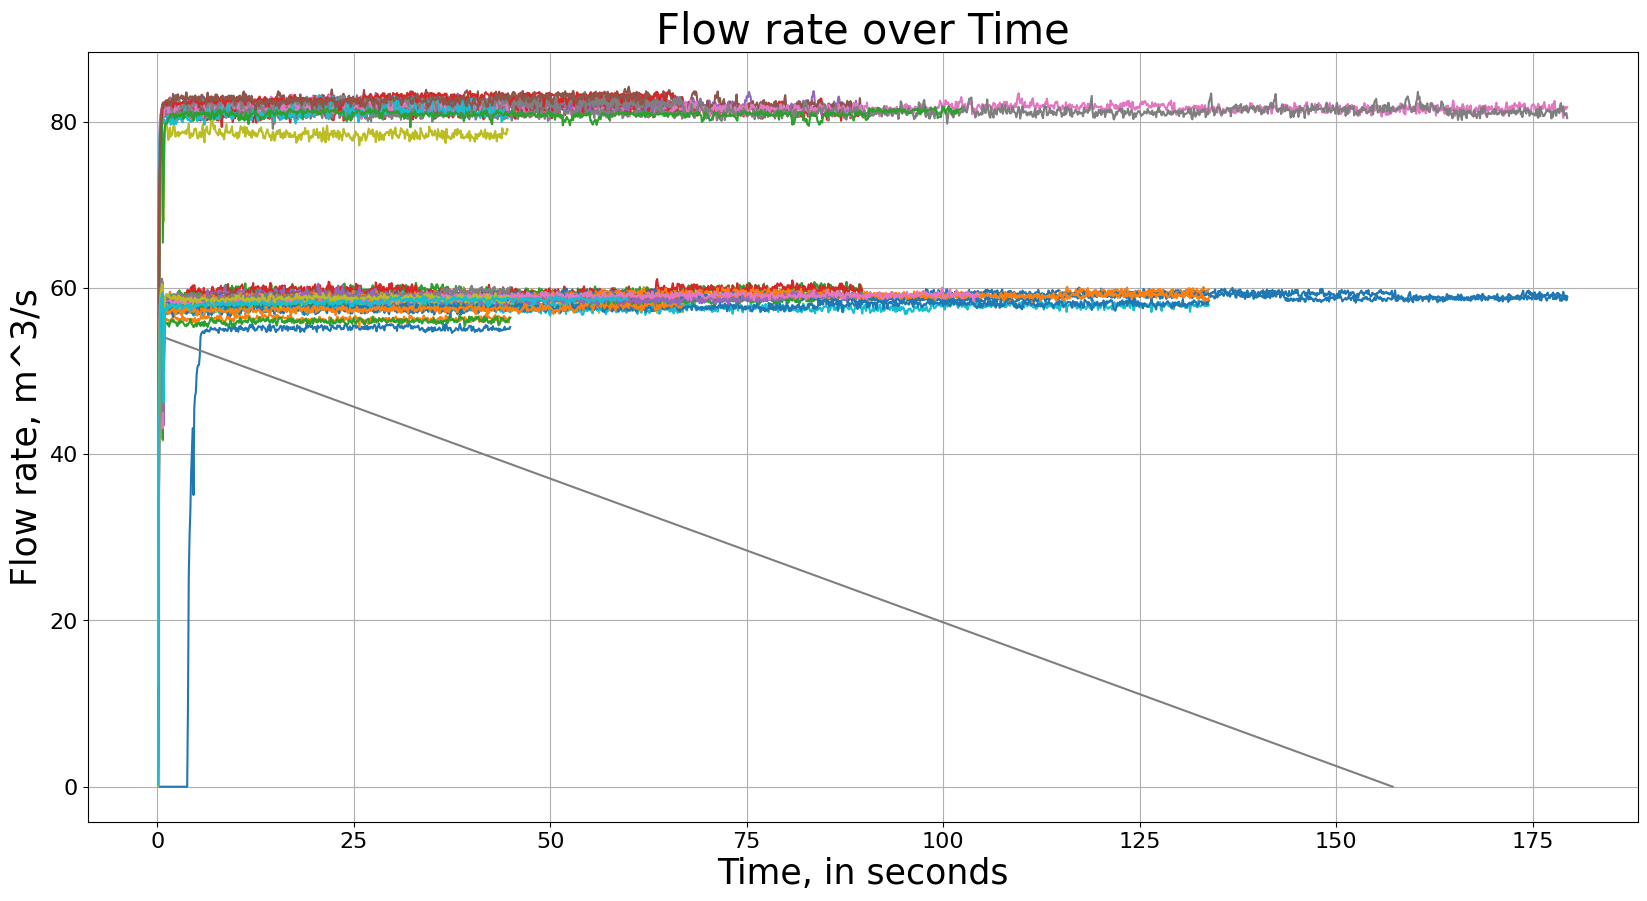

In [10]:
# checking the flow rate over time
plt.figure(figsize = (20,10))
for data_no, df in train_df.groupby('Data_No'):
    plt.plot(df['Time'], df['Flow_rate'])
plt.xlabel('Time, in seconds', fontsize=25)
plt.ylabel('Flow rate, m^3/s', fontsize=25)
plt.tick_params(axis='both', labelsize=16)
plt.title('Flow rate over Time', fontsize=30)
plt.grid()

The flow rate appears to remain constant overtime. There are 2 different flow rates observed - about 60 m^3/s and ~80 m^3/s

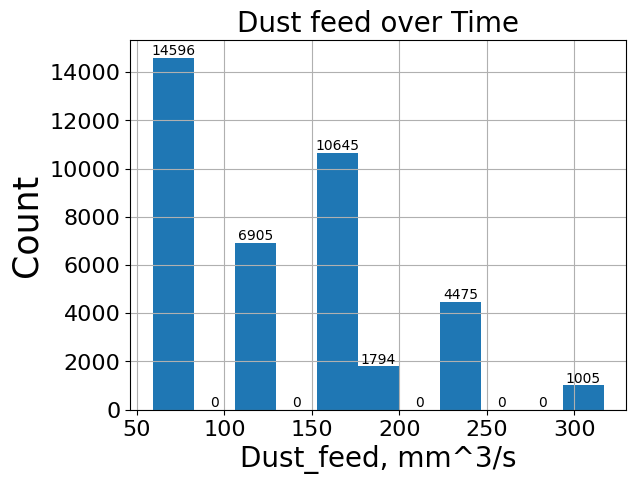

In [11]:
# dust feed distribution
import seaborn as sns
counts, edges, bars = plt.hist(data=train_df, x="Dust_feed", bins=11)
plt.bar_label(bars)
plt.xlabel('Dust_feed, mm^3/s', fontsize=20)
plt.ylabel('Count', fontsize=25)
plt.tick_params(axis='both', labelsize=16)
plt.title('Dust feed over Time', fontsize=20)
plt.grid()

Various sizes of Arizona Dust particles are introduced into the compressed air system. The distbution plot shows the dust feed rate over number of test runs. In the data set, the current material feed is given in mm3/s. Together with the bulk density of the dusts of-

A2 Fine Test Dust - 0.900g/cm3,
A3 Medium Test Dust - 1.025g/cm3,
A4 Coarse Test Dust - 1.200g/cm3,
the mass of the fed dust can be calculated.

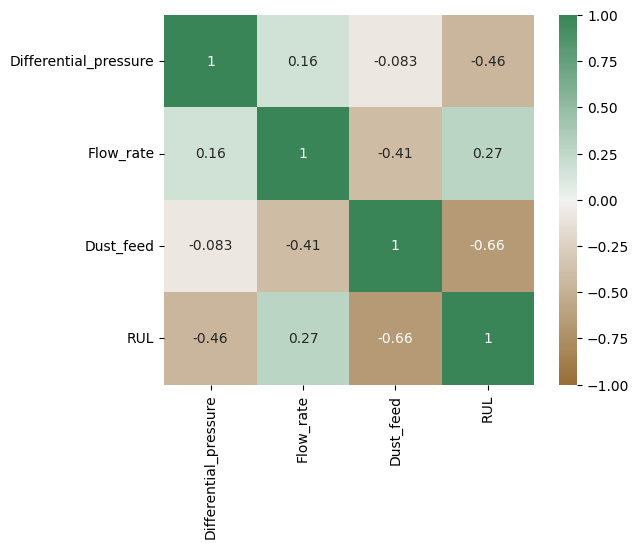

In [12]:
# checking the correlation plot of various parameters in the test data
corr_matrix = test_df[["Differential_pressure","Flow_rate","Dust_feed","RUL"]].corr()

axis_corr = sns.heatmap(
corr_matrix,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(50, 500, n=500),
square=True,
annot = True
)

plt.show()

The correlation matrix indicates there is a weak correlation between flow rate and remaining useful life. There a negative correlation between dust feed and the remaining useful life and differential pressure & RUL. 

Based on the article in kaggle from Michael Holting(https://www.kaggle.com/code/michaelhotaling2/calculating-remaining-useful-life-using-an-rnn), the 50 different time series data is reshaped. This data is divided into sequences of timesteps. Each sequence contains about 20 time steps. Using each time sequence as input, the value of differential pressure is predicted.

## Time series analysis

In [13]:
# This function splits the input data into sequences and returns them as a generator
def x_reshape(df, columns, sequence_length):
    data = df[columns].values
    num_elements = data.shape[0]
    for start, stop in zip(range(0, 
                                 num_elements-sequence_length-10), # 10 = predicted time steps in future 
                           range(sequence_length,
                                 num_elements-10)):
        yield(data[start:stop, :])

# This function creates sequences of input data        
def get_x_slices(df, feature_columns):
    # Reshape the data to (samples, time steps, features)
    feature_list = [list(x_reshape(df[df['Data_No'] == i], feature_columns, 20)) #20 = sequences_length
                    for i in range(1, df['Data_No'].nunique() + 1) if len(df[df['Data_No']  == i]) > 20]
    feature_array = np.concatenate(list(feature_list), axis=0).astype(np.float64)

    length = len(feature_array) // 128
    return feature_array[:length*128]

# This function creates labels for the output data
def y_reshape(df, sequence_length, columns=['Differential_pressure']):
    data = df[columns].values
    num_elements = data.shape[0]
    return(data[sequence_length+10:num_elements, :])

# This function creates sequences of output data
def get_y_slices(df):
    label_list = [y_reshape(df[df['Data_No'] == i], 20) 
                  for i in range(1, df['Data_No'].nunique()+1)]
    label_array = np.concatenate(label_list).astype(np.float64)
    length = len(label_array) // 128
    return label_array[:length*128]

## Splitting the data into test and train data

In [14]:
X_train = get_x_slices(train_df, ['Differential_pressure'])
X_test = get_x_slices(test_df,['Differential_pressure'])
y_train = get_y_slices(train_df)
y_test = get_y_slices(test_df)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37888, 20, 1)
(37888, 20, 1)
(37888, 1)
(37888, 1)


In [16]:
# Drop the last axis
X_train = np.squeeze(X_train, axis=2)
y_train = np.squeeze(y_train, axis=1)
X_test = np.squeeze(X_test, axis=2)
y_test = np.squeeze(y_test, axis=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37888, 20)
(37888, 20)
(37888,)
(37888,)


In [17]:
# split train data in 90% train, 10% validation
train_size = int(len(X_train) * 0.9)
X_train, X_val = X_train[:train_size], X_train[train_size:]
y_train, y_val = y_train[:train_size], y_train[train_size:]

print("X Shape:", X_train.shape)
print("X Shape:", X_val.shape)

X Shape: (34099, 20)
X Shape: (3789, 20)


In [18]:
# Scale the data to a value between 0 and 1
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Building the model

In [19]:
#R2 score & MAE, MSE and RMSE
def evaluate(y_true, y_pred, label='test'):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print('{} set MAE:{}, R2:{}, RMSE:{}'.format(label, mae, r2, rmse))

### Linear Regression model

In [20]:
from sklearn.metrics import mean_squared_error
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#prediction on training dataset
y_lr_train = lin_reg.predict(X_train) 
evaluate(y_train, y_lr_train, label='train')

#prediction on test dataset
y_lr_test = lin_reg.predict(X_test) 
evaluate(y_test, y_lr_test, label='test')

train set MAE:3.6707303996872818, R2:0.9965893402205237, RMSE:6.0279494662841735
test set MAE:4.654406140473434, R2:0.9961945249883997, RMSE:7.472944577450568


### Support Vector Machines

In [21]:
sv = SVR(kernel='rbf')
sv.fit(X_train, y_train)

 #Prediction on train data
y_sv_train = sv.predict(X_train)
evaluate(y_train, y_sv_train, label='train')

#Prediction on test data
y_sv_test = sv.predict(X_test)  
evaluate(y_test, y_sv_test, label='test')

train set MAE:4.094235716344109, R2:0.9929655325118513, RMSE:8.656972070042137
test set MAE:5.010270686328229, R2:0.99460760749459, RMSE:8.895657887582356


### Random Forest

In [22]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

#Prediction on train data
y_rf_train = rf.predict(X_train) 
evaluate(y_train,y_rf_train, label='train')

#Prediction on test data
y_rf_test = rf.predict(X_test)
evaluate(y_test, y_rf_test, label='test')

train set MAE:1.0071134159192237, R2:0.9997281442174689, RMSE:1.701843775440798
test set MAE:4.541044526098878, R2:0.9962217957006536, RMSE:7.446120207548193


### KNN model

In [23]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

y_knn_train = knn.predict(X_train) #Prediction on train data
evaluate(y_train,y_knn_train, label='train')

y_knn_test = knn.predict(X_test)  #Prediction on test data
evaluate(y_test, y_knn_test, label='test')

train set MAE:2.0600600280222294, R2:0.9988684341936164, RMSE:3.4720846972997843
test set MAE:5.0065194149678005, R2:0.9949522453416991, RMSE:8.60669560051248


In [24]:
dt = pd.DataFrame({'model': ['Linear Regression', 'SVR', 'Random Forest', 'KNN'], 
             'train MAE': [3.6707, 4.0942, 1.0062, 2.06009],
             'test MAE': [4.6544, 5.0102, 4.5534, 5.00651],
                  'train RMSE': [6.0279, 8.656, 1.6944, 3.472],
                  'test RMSE': [7.4729, 8.895, 7.462, 8.606]}).set_index('model')

C:\Users\vchivukula\AppData\Local\Temp\ipykernel_14548\126381945.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(["LR", "SVR", "RF", "KNN"],rotation=45)
C:\Users\vchivukula\AppData\Local\Temp\ipykernel_14548\126381945.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(["LR", "SVR", "RF", "KNN"],rotation=45)
C:\Users\vchivukula\AppData\Local\Temp\ipykernel_14548\126381945.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(["LR", "SVR", "RF", "KNN"],rotation=45)
C:\Users\vchivukula\AppData\Local\Temp\ipykernel_14548\126381945.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xtickl

Text(0, 0.5, 'Error')

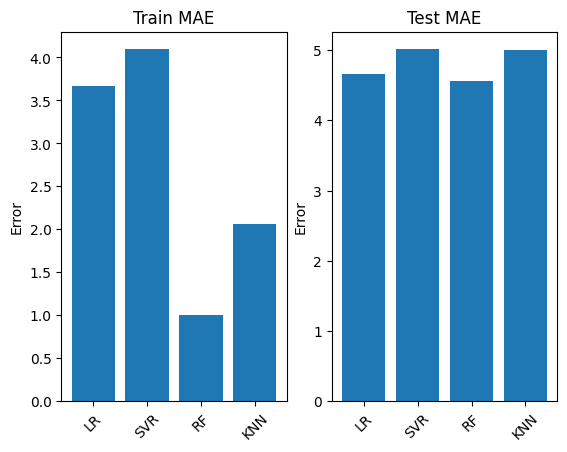

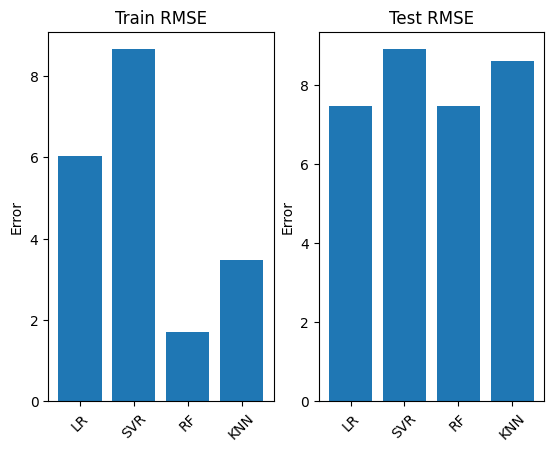

In [25]:
fig1, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(dt.index, dt['train MAE'])
ax1.set_title('Train MAE')
ax1.set_xticklabels(["LR", "SVR", "RF", "KNN"],rotation=45)
ax1.set_ylabel("Error")
ax2.bar(dt.index, dt['test MAE'])
ax2.set_title('Test MAE')
ax2.set_xticklabels(["LR", "SVR", "RF", "KNN"],rotation=45)
ax2.set_ylabel("Error")
fig2, (ax3, ax4) = plt.subplots(1, 2)
ax3.bar(dt.index, dt['train RMSE'])
ax3.set_title('Train RMSE')
ax3.set_xticklabels(["LR", "SVR", "RF", "KNN"],rotation=45)
ax3.set_ylabel("Error")
ax4.bar(dt.index, dt['test RMSE'])
ax4.set_title('Test RMSE')
ax4.set_xticklabels(["LR", "SVR", "RF", "KNN"],rotation=45)
ax4.set_ylabel("Error")

Out of 4 different models (Linear Regression, Support Vector, Random Forest, and KNN) that were explored. The mean absolute error for the Random forest algorirm has the lowest (~1.0062).

When we look at the root mean squared error (RMSE), random forest has lowest RMSE of 1.69 for train and validation datasets. 

### Hyperparameter tuning using gridsearch

In [35]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300],
    'max_features': ['log2', 'sqrt']
}
# Instantiate the grid search model
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
grid_search.fit(X_val, y_val)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'max_depth': [10, 30, 50],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [36]:
final_model = grid_search.best_estimator_
print(final_model)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300)


In [37]:
score = grid_search.best_score_
print(score)

-7.188165540632349


### Evaluating the final tuned model

In [38]:
rf = final_model
rf.fit(X_train, y_train)

#Prediction on train data
y_rf_train = rf.predict(X_train) 
evaluate(y_train,y_rf_train, label='train')

#Prediction on test data
y_rf_test = rf.predict(X_test)  
evaluate(y_test, y_rf_test, label='test')

train set MAE:2.578910517111738, R2:0.99859544926642, RMSE:3.868290831781479
test set MAE:4.665397094488756, R2:0.9959907696239647, RMSE:7.670396782231588


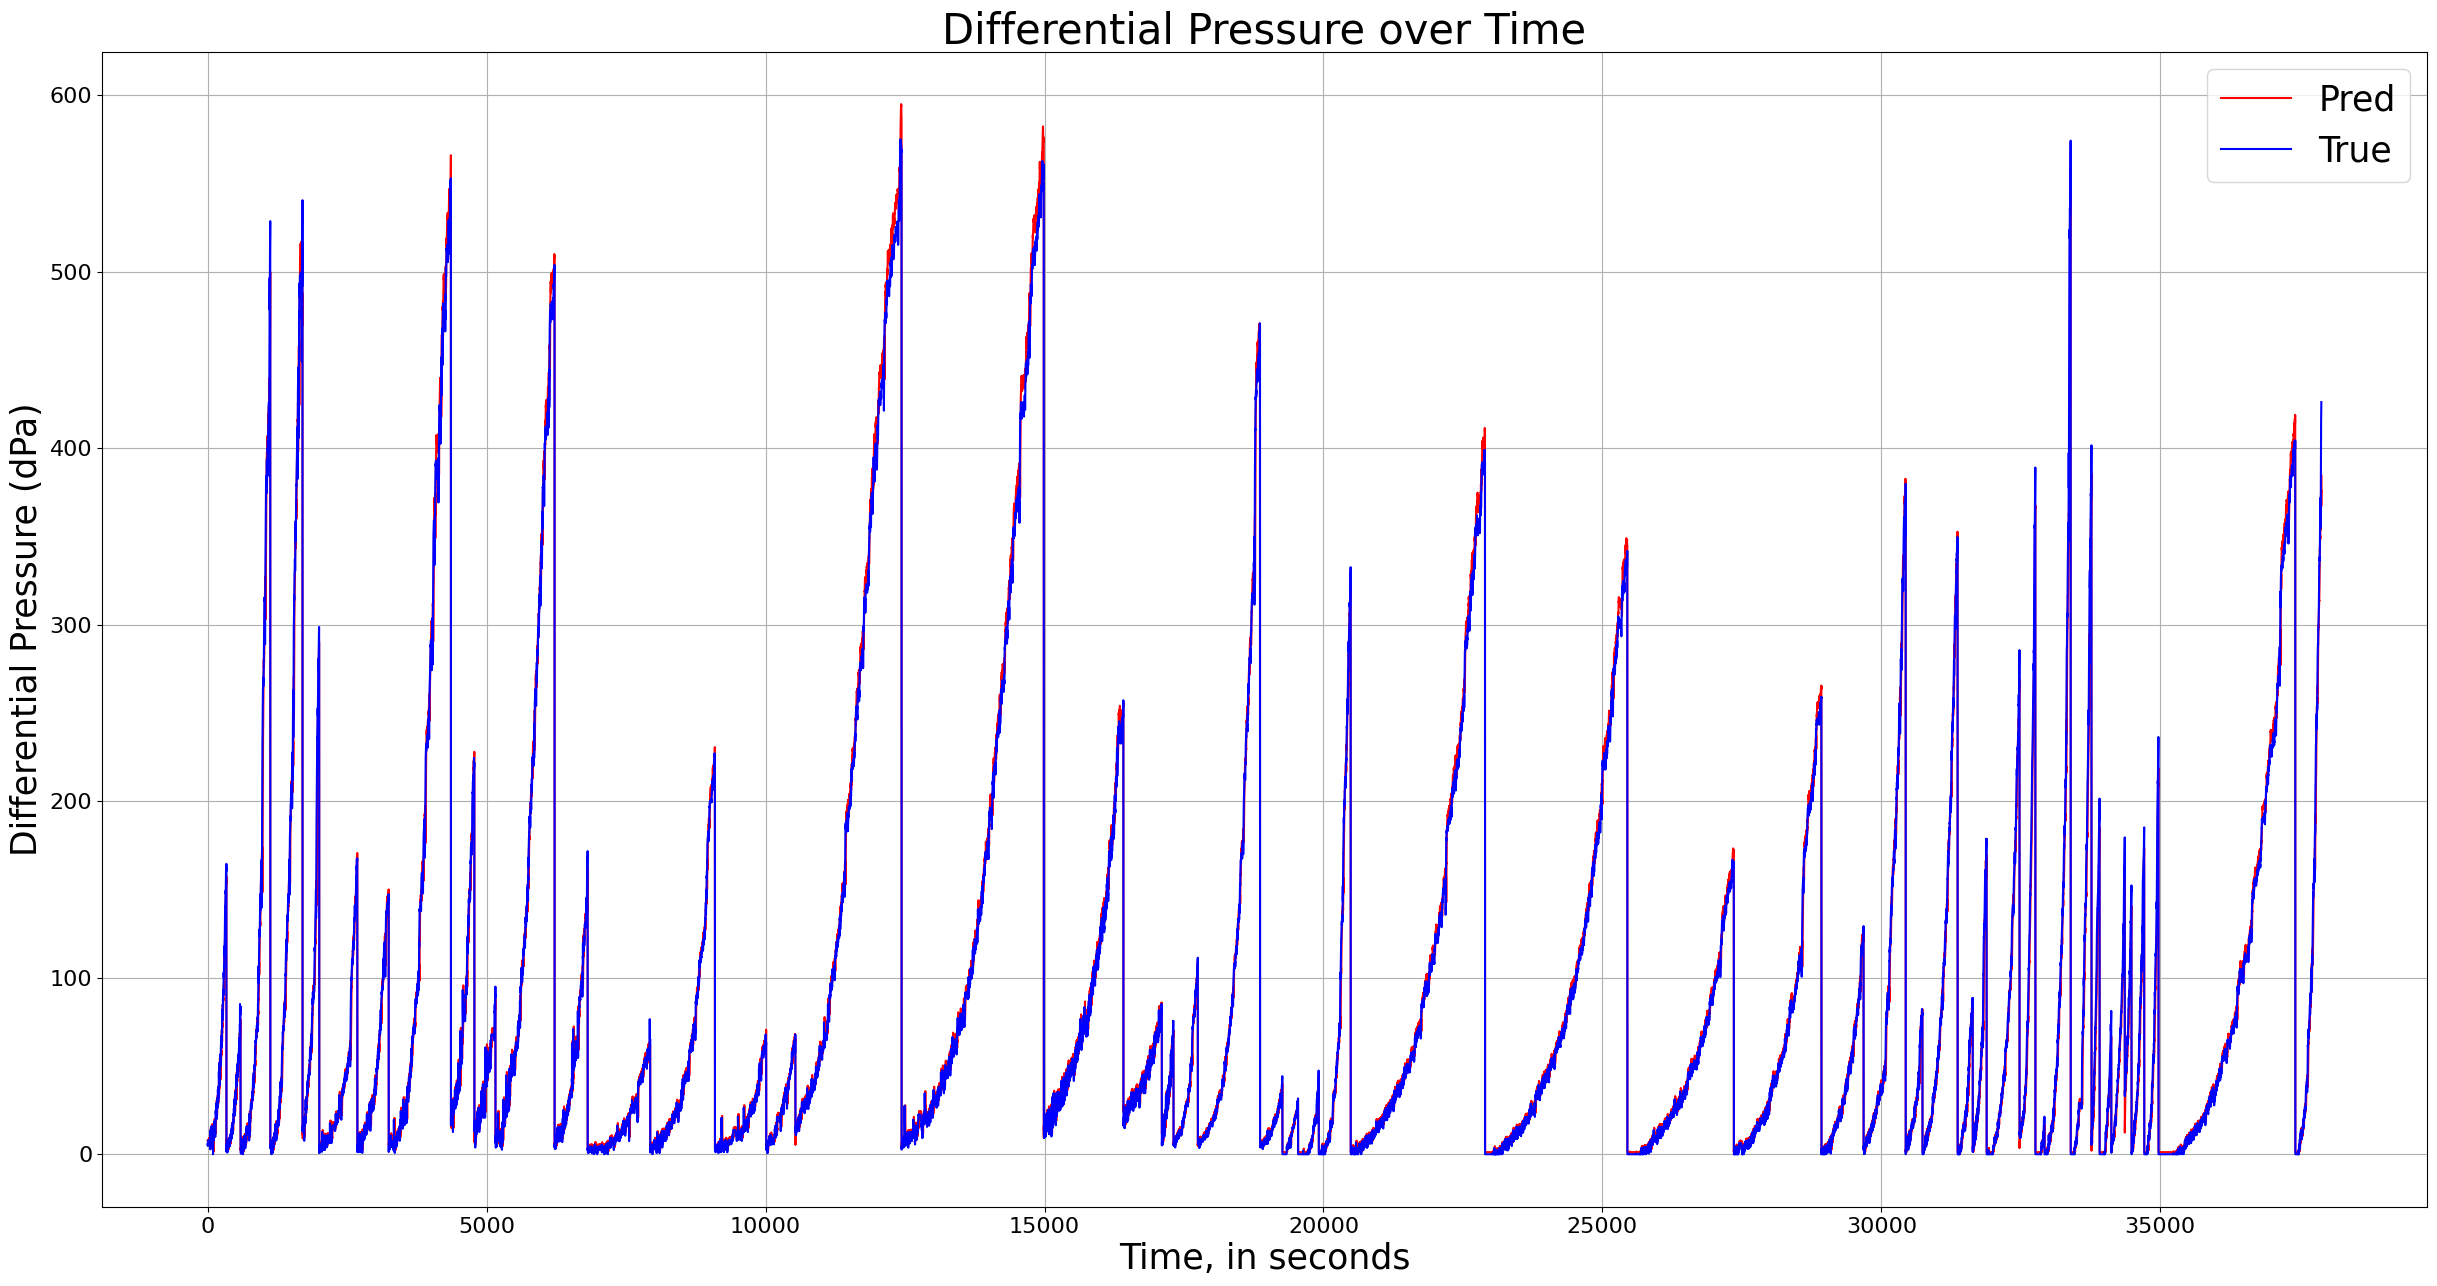

In [39]:
# Plot true and predicted values
plt.figure(figsize=(30,15))
plt.plot(y_lr_test, label = "Pred", color = "red")
plt.plot(y_test, label = "True", color = "blue")
plt.xlabel('Time, in seconds', fontsize=25)
plt.ylabel('Differential Pressure (dPa)', fontsize=25)
plt.tick_params(axis='both', labelsize=16)
plt.title('Differential Pressure over Time', fontsize=30)
plt.grid()
plt.legend(loc="upper right", fontsize=25)
plt.show()

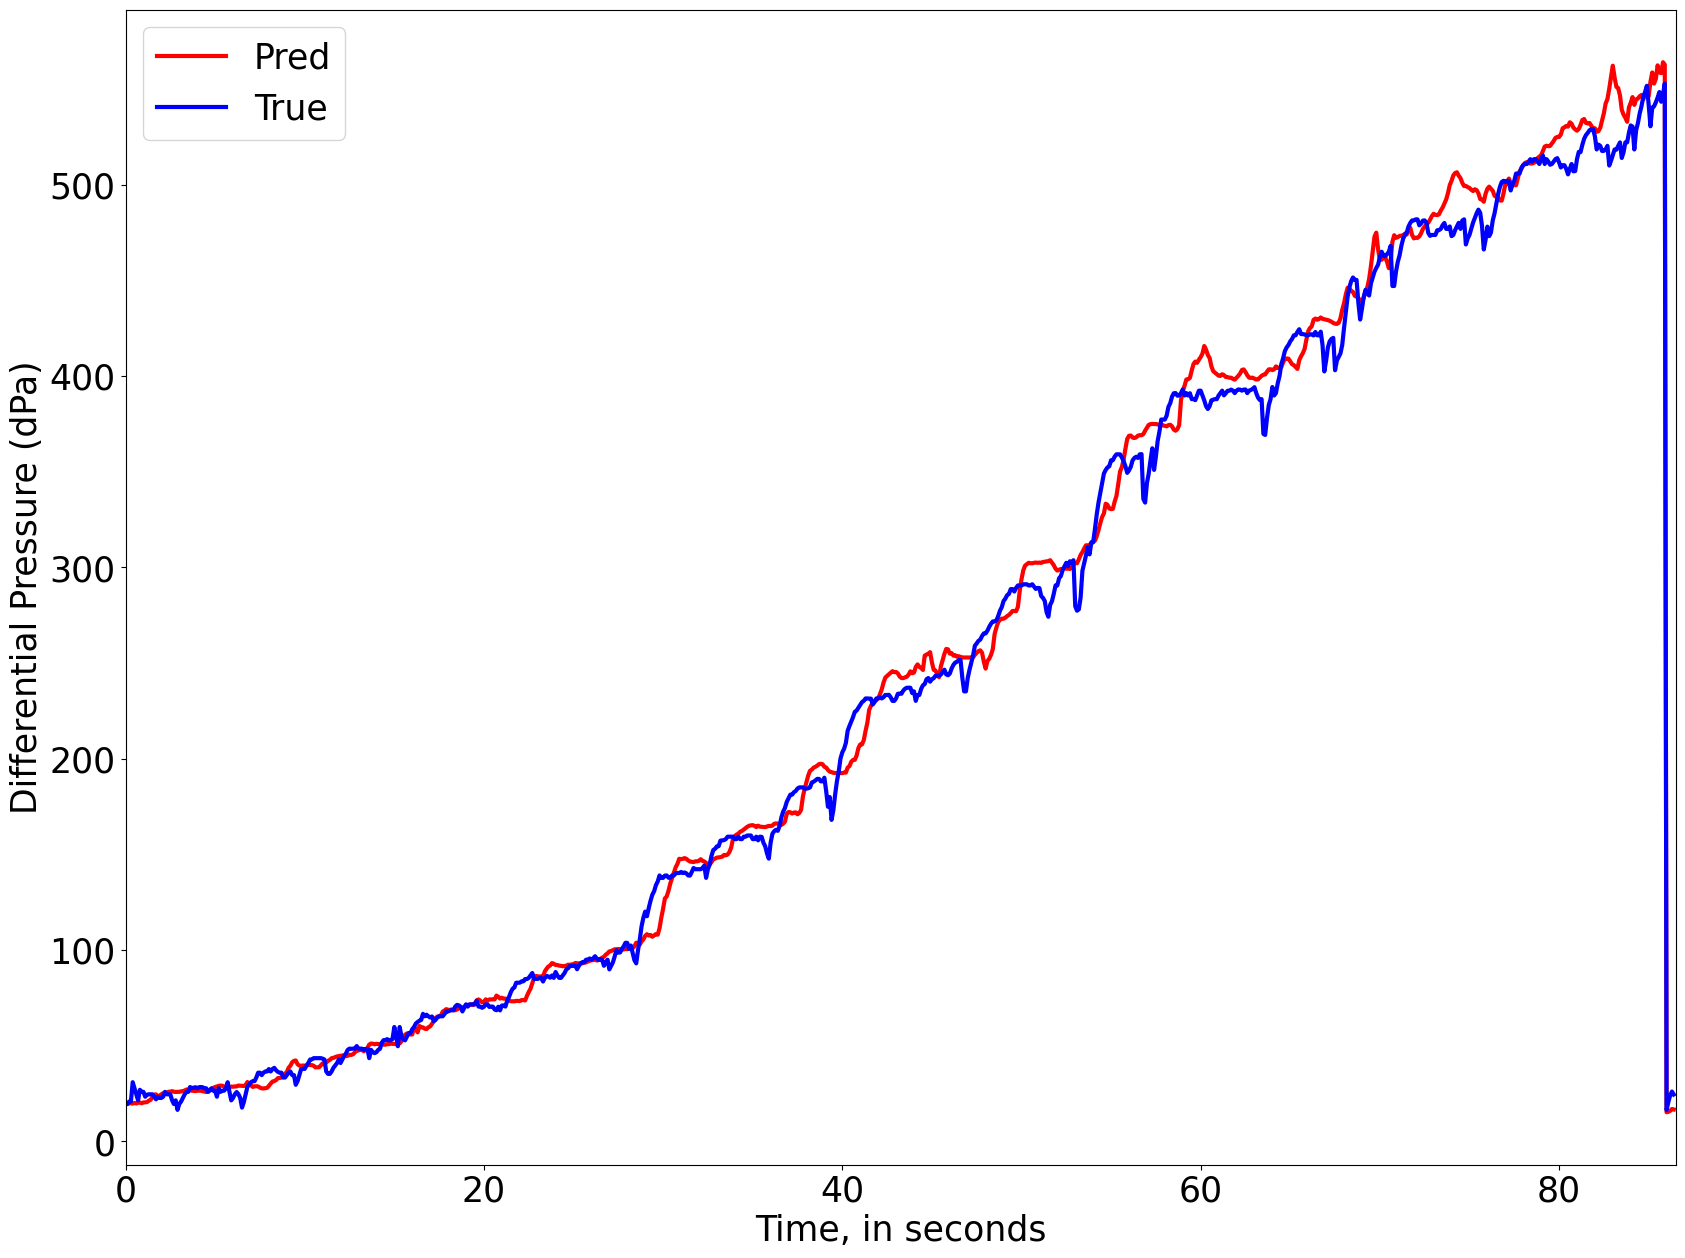

In [40]:
# plot only part:
y_lr_test_part = y_rf_test[3500:4365]
y_test_part = y_test[3500:4365]
# Plot true and predicted values
plt.figure(figsize=(20,15))
plt.plot(y_lr_test_part, label = "Pred", color = "red", linewidth=3)
plt.plot(y_test_part, label = "True", color = "blue", linewidth=3)
plt.legend(fontsize=25)
plt.tick_params(axis='both', labelsize=25)
plt.xlabel('Time, in seconds', fontsize=25)
plt.ylabel('Differential Pressure (dPa)', fontsize=25)

#for seconds in x axis

# Get the current x-axis ticks
xticks = plt.xticks()[0]

# Modify the x-axis ticks by dividing by a factor of 10
new_xticks = [int(tick/10) for tick in xticks]

# Set the new x-axis ticks
plt.xticks(xticks, new_xticks)

# Set the limits of the x-axis
plt.xlim([0, len(y_test_part)])

plt.savefig('pred_diff_rf', dpi=500, bbox_inches='tight')

plt.show()

### Confusion Matrix

In [43]:
pred_failures = y_rf_test >=500
real_failures = y_test >=500

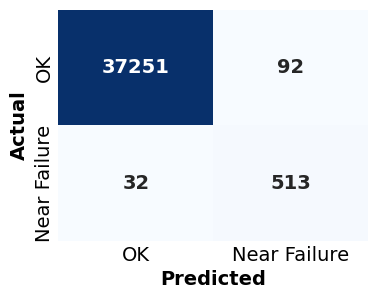

In [44]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(real_failures,pred_failures), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['OK', 'Near Failure'])
ax.set_yticklabels(['OK', 'Near Failure'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')

plt.savefig('conf_matrix_rf_530.png', dpi=500, bbox_inches='tight')

plt.show()

In [45]:
# Classification Report for RF classifier
from sklearn.metrics import classification_report
print(classification_report(real_failures, pred_failures))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     37343
        True       0.85      0.94      0.89       545

    accuracy                           1.00     37888
   macro avg       0.92      0.97      0.95     37888
weighted avg       1.00      1.00      1.00     37888



In [46]:
pred_failures = y_rf_test >=500
real_failures = y_test >=530

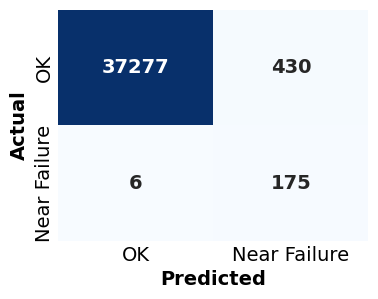

In [47]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(real_failures,pred_failures), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['OK', 'Near Failure'])
ax.set_yticklabels(['OK', 'Near Failure'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')

plt.savefig('conf_matrix_rf_530.png', dpi=500, bbox_inches='tight')

plt.show()

In [48]:
# Classification Report for RF classifier
from sklearn.metrics import classification_report
print(classification_report(real_failures, pred_failures))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99     37707
        True       0.29      0.97      0.45       181

    accuracy                           0.99     37888
   macro avg       0.64      0.98      0.72     37888
weighted avg       1.00      0.99      0.99     37888



### ROC curve

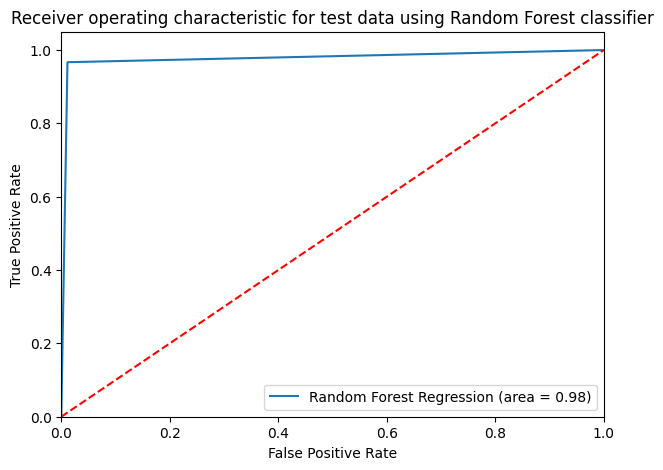

In [49]:
#ROC-AUC curve on test data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
rf_roc_auc_train = roc_auc_score(real_failures, pred_failures)
fpr, tpr, thresholds = roc_curve(real_failures, pred_failures)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % rf_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for test data using Random Forest classifier')
plt.legend(loc="lower right")
plt.show()

Feature selection, RMSE. 

### Recursive Neural Network Model for predicting "Remaining Useful Life (RUC)"

An RNN (Recurrent Neural Network) is a type of neural network that utilizes the previous observations in its input to predict future outcomes. In this case, the input is two-dimensional, where the last 'n' observations are considered as input. For instance, if we take the last 20 observations as input, the predicted value would be the remaining useful life after those 20 observations. To prepare the data for the RNN, we need to reshape it using specific functions.

In [69]:
# Load the data from kaggle
train_df = pd.read_csv('data/Train_Data_RNN.csv')
test_df = pd.read_csv('data/Test_Data_RNN.csv')

train_df.columns = ["Data_No","Differential_pressure","Flow_rate","Time","Dust_feed","RUL","Sampling","Bias_type"]
train_df = train_df[["Data_No","Differential_pressure","Flow_rate","Time","Dust_feed","Sampling","RUL","Bias_type"]]
print(train_df.head().to_markdown(index=False), end = "\n\n")

print(test_df.head().to_markdown(index=False))

|   Data_No |   Differential_pressure |   Flow_rate |   Time |   Dust_feed |   Sampling |   RUL | Bias_type   |
|----------:|------------------------:|------------:|-------:|------------:|-----------:|------:|:------------|
|         1 |                11.0178  |     34.5004 |    0.1 |     177.313 |         10 | 131.1 | b           |
|         1 |                 0       |     61.5364 |    0.2 |     177.313 |         10 | 131   | b           |
|         1 |                 4.05526 |     72.3324 |    0.3 |     177.313 |         10 | 130.9 | b           |
|         1 |                 0       |     77.1332 |    0.4 |     177.313 |         10 | 130.8 | b           |
|         1 |                 0       |     79.4708 |    0.5 |     177.313 |         10 | 130.7 | b           |

|   Data_No |   Differential_pressure |   Flow_rate |   Time |   Dust_feed |   Sampling |   RUL | Bias_type   |
|----------:|------------------------:|------------:|-------:|------------:|-----------:|------:|:-----

In [70]:
def x_reshape(df, columns, sequence_length):
    data = df[columns].values
    num_elements = data.shape[0]
    for start, stop in zip(range(0, 
                                 num_elements-sequence_length), 
                           range(sequence_length,
                                 num_elements)):
        yield(data[start:stop, :])

def get_x_slices(df, feature_columns):
    # Reshape the data to (samples, time steps, features)
    feature_list = [list(x_reshape(df[df['Data_No'] == i], feature_columns, 100)) 
                    for i in range(1, df['Data_No'].nunique() + 1) if len(df[df['Data_No']  == i]) > 100]
    feature_array = np.concatenate(list(feature_list), axis=0).astype(np.float64)

    length = len(feature_array) // 128
    return feature_array[:length*128]

def get_data_id(df):
    label_list = [y_reshape(df[df['Data_No'] == i], 100, columns  = ['Data_No']) 
                  for i in range(1, df['Data_No'].nunique()+1)]
    label_array = np.concatenate(label_list).astype(np.int64)
    length = len(label_array) // 128
    return label_array[:length* 128]

def y_reshape(df, sequence_length, columns=['RUL']):
    data = df[columns].values
    num_elements = data.shape[0]
    return(data[sequence_length:num_elements, :])
        
def get_y_slices(df):
    label_list = [y_reshape(df[df['Data_No'] == i], 100) 
                  for i in range(1, df['Data_No'].nunique()+1)]
    label_array = np.concatenate(label_list).astype(np.float64)
    length = len(label_array) // 128
    return label_array[:length*128]

In [71]:
scaler = MinMaxScaler()
X_train = get_x_slices(train_df, ['Differential_pressure','Flow_rate','Time','Dust_feed'])
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = get_x_slices(test_df,['Differential_pressure','Flow_rate','Time','Dust_feed'])
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train = get_y_slices(train_df)
y_test = get_y_slices(test_df)
assert(y_train.shape[0] == X_train.shape[0])
assert(y_test.shape[0] == X_test.shape[0])

In [73]:
model = Sequential()
model.add(LSTM(input_shape=(X_train.shape[1], 
                            X_train.shape[2]), 
               units=10, 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30, 
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=25, 
               return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Dropout(0.2))
model.add(Activation("linear"))

model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['mse','mae'])

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 10)           600       
                                                                 
 dropout_5 (Dropout)         (None, 100, 10)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 50)           12200     
                                                                 
 dropout_6 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 30)           9720      
                                                                 
 dropout_7 (Dropout)         (None, 100, 30)           0         
                                                                 
 lstm_7 (LSTM)               (None, 25)               

A RNN model with 28146 parameters was built, it consist's of 4 LSTM layers with dropout after each and a single dense layer of 26 parameters. The activation is linear and the mae and mse are used as metrics. 

In [75]:
es = EarlyStopping(monitor='val_mae',  
                   patience=5, 
                   verbose=True)

A early stopping object is used to prevent overfitting and improve the generalization of the model. In this case, it checks the validation mae and stops training if the validation MAE doesn't improve for 5 consecutive epochs.

In [78]:
history = model.fit(X_train,
                    y_train,
                    epochs=30, 
                    validation_data=(X_test, 
                                     y_test), 
                    callbacks=[es])

Epoch 1/30
1216/1216 [==============================] - 128s 105ms/step - loss: 1027.3872 - mse: 1027.3872 - mae: 19.5092 - val_loss: 379.3759 - val_mse: 379.3759 - val_mae: 16.5869
Epoch 2/30
1216/1216 [==============================] - 129s 106ms/step - loss: 1001.6723 - mse: 1001.6723 - mae: 19.0481 - val_loss: 258.4582 - val_mse: 258.4582 - val_mae: 13.7309
Epoch 3/30
1216/1216 [==============================] - 150s 123ms/step - loss: 988.8849 - mse: 988.8849 - mae: 18.7612 - val_loss: 346.9005 - val_mse: 346.9005 - val_mae: 16.5573
Epoch 4/30
1216/1216 [==============================] - 189s 155ms/step - loss: 1005.5422 - mse: 1005.5422 - mae: 18.7127 - val_loss: 337.1906 - val_mse: 337.1906 - val_mae: 16.0894
Epoch 5/30
1216/1216 [==============================] - 172s 141ms/step - loss: 974.9882 - mse: 974.9882 - mae: 18.3169 - val_loss: 232.3994 - val_mse: 232.3994 - val_mae: 12.9169
Epoch 6/30
1216/1216 [==============================] - 252s 207ms/step - loss: 962.8631 - mse

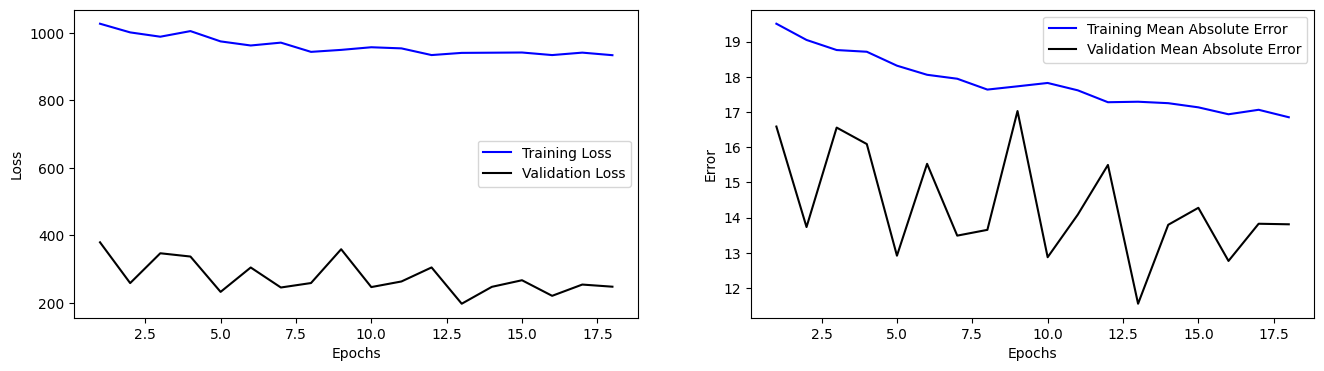

In [85]:
# plot the loss, mse and mae for training and validation datasets
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,4))

ax1.plot(np.arange(1,
                   len(history.history['loss']) + 1), 
         history.history['loss'], 
         color = 'blue', 
         label = 'Training Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax1.plot(np.arange(1,
                   len(history.history['val_loss']) + 1), 
         history.history['val_loss'], 
         color = 'black', 
         label = 'Validation Loss')
ax1.legend()

ax2.plot(np.arange(1,
                   len(history.history['mae']) + 1), 
         history.history['mae'], 
         color = 'blue', 
         label = 'Training Mean Absolute Error')

ax2.plot(np.arange(1,
                   len(history.history['val_mae']) + 1), 
         history.history['val_mae'], 
         color = 'black', 
         label = 'Validation Mean Absolute Error')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Error")
ax2.legend();

In [86]:
# prediction on test data
pred = model.predict(X_test)

524/524 [==============================] - 15s 26ms/step


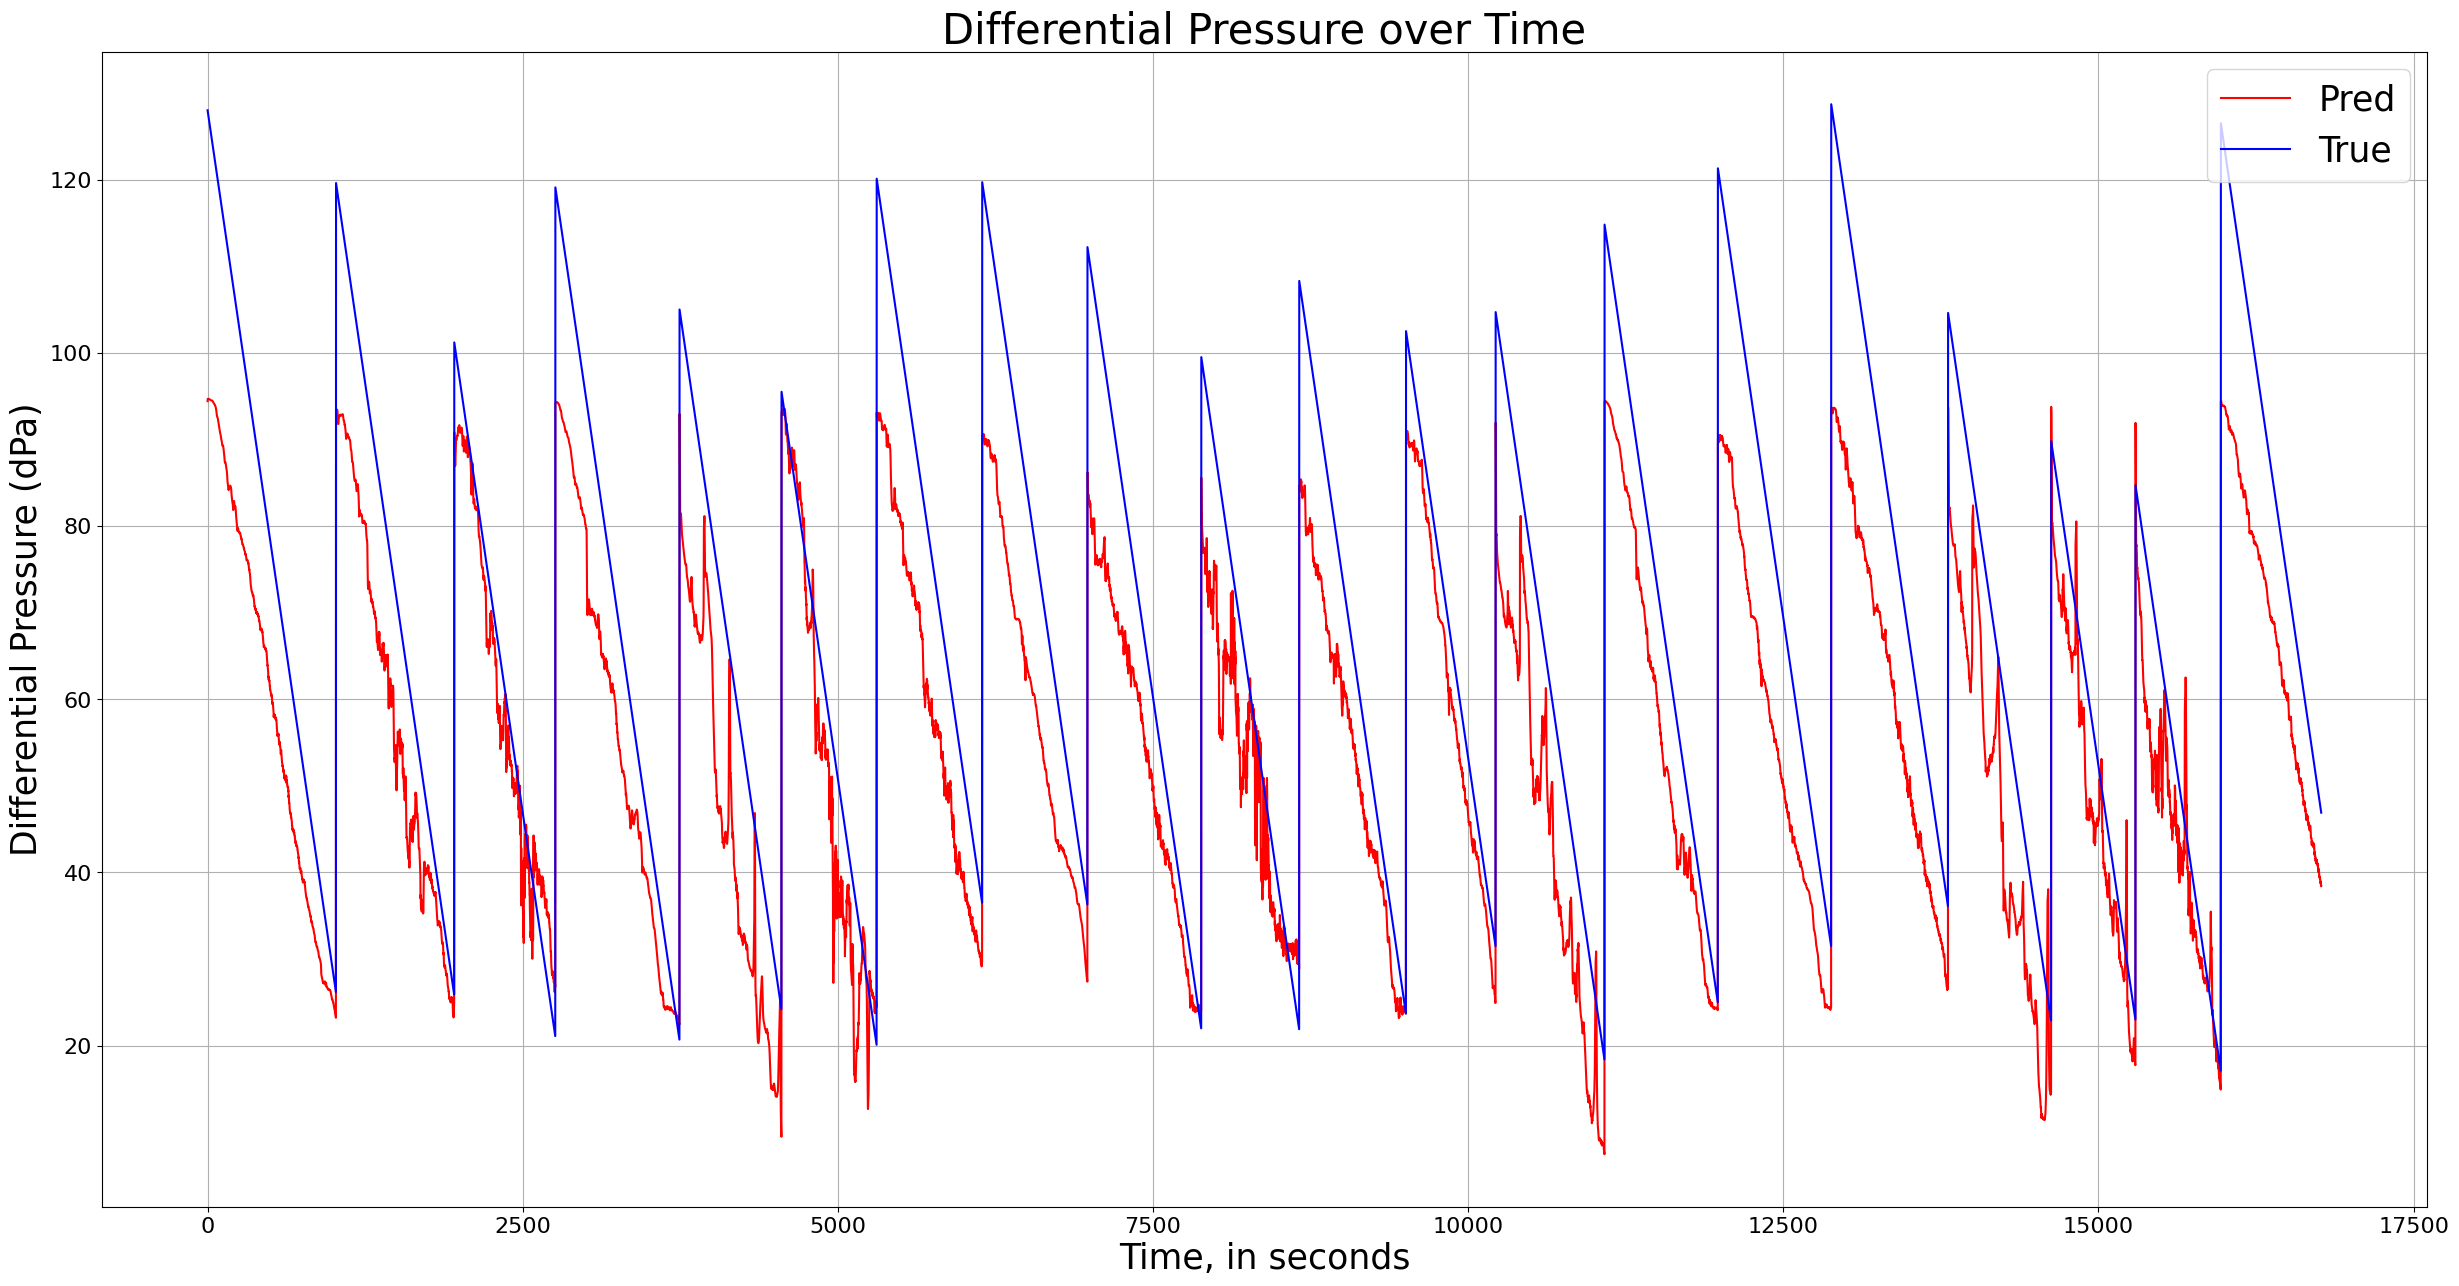

In [87]:
# Plot true and predicted values
plt.figure(figsize=(30,15))
plt.plot(pred, label = "Pred", color = "red")
plt.plot(y_test, label = "True", color = "blue")
plt.xlabel('Time, in seconds', fontsize=25)
plt.ylabel('Differential Pressure (dPa)', fontsize=25)
plt.tick_params(axis='both', labelsize=16)
plt.title('Differential Pressure over Time', fontsize=30)
plt.grid()
plt.legend(loc="upper right", fontsize=25)
plt.show()

### Conclusion: 
The random forest model appears to make a better prediction of differential pressur then RNN model (using LSTM). Both Random Forest and RNN models could be used predict the RUL of a filter and plan pro-active maintenence event before the filter reaches end of life. 

### Next steps and recommendations:
Improve the accuracy of RNN model by adding more epochs and with multiple dense layers at the output. Use techniques learned in the course such as data augumentation and drop out with better fine tuning of the layers and number of parameters to achieve lower loss and error in prediction of remaining useful life (RUL) of the filter.   